In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold #AÑADIDO A DIFERENCIA DEL DE DANI
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random as rn

import time #agregado por diego
print("Versión de TensorFlow:", tf.__version__)

Versión de TensorFlow: 2.12.0


In [3]:
# Parámetros del modelo
input_shape = (158, 158, 3)  # Tamaño de las imágenes
num_clases = 3  # Número de clases

In [23]:
#listas para almacecnar imagenes y etiquetas
Imagenes=[]
Etiquetas=[]
#tamaño de las imagenes
IMG_TAM = 158
#definicion de los directorios de cada clase
DIR_BASE = 'D:\OneDrive\Documentos\8Semestre\TT2\Imagenes clasificadas'
DIR_ENFERMO_SR = DIR_BASE+'\Enfermo\Stem end Rot'
DIR_ENFERMO_BR = DIR_BASE+'\Enfermo\Body rot'
#DIR_ENFERMO = DIR_BASE+'/Enfermo
DIR_SANO = DIR_BASE+'\Sano'
DIR_SANO_brillo = DIR_BASE+'\Sano\Augmented\\brillo'
DIR_SANO_cs = DIR_BASE + '\Sano\Augmented\channel_shift'
DIR_SANO_flip = DIR_BASE + '\Sano\Augmented\\flip_horizontal'
DIR_SANO_rotacion = DIR_BASE + '\Sano\Augmented\\rotacion'
DIR_SANO_zoom = DIR_BASE + '\Sano\Augmented\zoom'

#Data augmentation
#data augmentation de BR
DIR_ENFERMO_BR_brillo = DIR_BASE + '\Enfermo\Body rot\Augmented\\brillo'
DIR_ENFERMO_BR_cs = DIR_BASE + '\Enfermo\Body rot\Augmented\channel_shift'
DIR_ENFERMO_BR_flip = DIR_BASE + '\Enfermo\Body rot\Augmented\\flip_horizontal'
DIR_ENFERMO_BR_rotacion = DIR_BASE + '\Enfermo\Body rot\Augmented\\rotacion'
DIR_ENFERMO_BR_zoom = DIR_BASE + '\Enfermo\Body rot\Augmented\zoom'

#data augmentation de SER
DIR_ENFERMO_SR_brillo = DIR_BASE + '\Enfermo\Stem end Rot\Augmented\\brillo'
DIR_ENFERMO_SR_cs = DIR_BASE + '\Enfermo\Stem end Rot\Augmented\channel_shift'
DIR_ENFERMO_SR_flip = DIR_BASE + '\Enfermo\Stem end Rot\Augmented\\flip_horizontal'
DIR_ENFERMO_SR_rotacion = DIR_BASE + '\Enfermo\Stem end Rot\Augmented\\rotacion'
DIR_ENFERMO_SR_zoom = DIR_BASE + '\Enfermo\Stem end Rot\Augmented\zoom'

DIR_ENFERMO_SR_IA = DIR_BASE + '\Enfermo\Stem end Rot\AI generated'
DIR_ENFERMO_BR_IA = DIR_BASE + '\Enfermo\Body rot\AI generated'



In [5]:
#funcion para listar las extenciones de archivos en un directorio
def obtener_extension_archivos(DIR):
  ext=[]
  for archivo in os.listdir(DIR):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    ext.append(ext_archivo)
  extensiones=set(ext)
  print(extensiones)


In [6]:
#validar si un archivo es una imagen en eel  formato permitido
def imagen_valida(archivo,extensiones=[".jpg",".png",".JPG",".PNG",".jfif",".jpeg"]):
  nom_archivo, ext_archivo = os.path.splitext(archivo)
  es_archivo = os.path.isfile(archivo)
  es_imagen = ext_archivo.lower() in extensiones
  return es_archivo and es_imagen

In [7]:
#muestra las extensiones de los archivos en los directorios a trabajar para ver si son válidos
obtener_extension_archivos(DIR_ENFERMO_SR)
obtener_extension_archivos(DIR_ENFERMO_BR)
obtener_extension_archivos(DIR_SANO)


{'.jpg', '', '.jfif', '.jpeg', '.PNG', '.JPG', '.webp', '.png'}
{'.jpg', '', '.jfif', '.jpeg', '.PNG', '.JPG', '.png'}
{'.jpg', '.jfif', '', '.avif', '.jpeg', '.JPG'}


In [8]:
#funcion para cargar umagenes y etiquetas el listas
def construir_base_datos(etiqueta, DIR):
  for archivo in tqdm(os.listdir(DIR)):
    #Construir ruta completa
    ruta = os.path.join(DIR,archivo)
    if imagen_valida(ruta):
      #Carga la imagen en RGB
      img = tf.keras.preprocessing.image.load_img(ruta,color_mode='rgb')
      #Convierte la imagen en una matriz de números
      matriz_img = tf.keras.preprocessing.image.img_to_array(img)
      #Redimenciona la imagen y normaliza la imagen [0 a 1]
      matriz_img = tf.image.resize(matriz_img/255,[IMG_TAM,IMG_TAM])
      #Agrega la matriz (array) a la lista
      Imagenes.append(matriz_img.numpy())
      #Añade la etiqueta a asociada a la imagen
      Etiquetas.append(etiqueta)


In [24]:
#CONSTRUCCION SIN EL DATA AUGMENTATION Y EL AI
clases=['Sano','Enfermo_BODYROT','Enfermo_STEMENDROT']
construir_base_datos(0, DIR_SANO)
construir_base_datos(0, DIR_SANO_brillo)
construir_base_datos(0, DIR_SANO_cs)
construir_base_datos(0, DIR_SANO_flip)
construir_base_datos(0, DIR_SANO_rotacion)
construir_base_datos(0, DIR_SANO_zoom)
print('\n',len(Etiquetas))
construir_base_datos(1, DIR_ENFERMO_BR)
construir_base_datos(1, DIR_ENFERMO_BR_brillo)
construir_base_datos(1, DIR_ENFERMO_BR_cs)
construir_base_datos(1, DIR_ENFERMO_BR_flip)
construir_base_datos(1, DIR_ENFERMO_BR_rotacion)
construir_base_datos(1, DIR_ENFERMO_BR_zoom)
print('\n',len(Etiquetas))
construir_base_datos(2, DIR_ENFERMO_SR)
construir_base_datos(2, DIR_ENFERMO_SR_brillo)
construir_base_datos(2, DIR_ENFERMO_SR_cs)
construir_base_datos(2, DIR_ENFERMO_SR_flip)
construir_base_datos(2, DIR_ENFERMO_SR_rotacion)
construir_base_datos(2, DIR_ENFERMO_SR_zoom)
construir_base_datos(2, DIR_ENFERMO_SR_IA)
print('\n',len(Etiquetas))

100%|██████████| 60/60 [00:08<00:00,  6.79it/s]



 489


100%|██████████| 52/52 [00:08<00:00,  5.90it/s]



 801


100%|██████████| 9/9 [00:00<00:00, 12.36it/s]


 1206


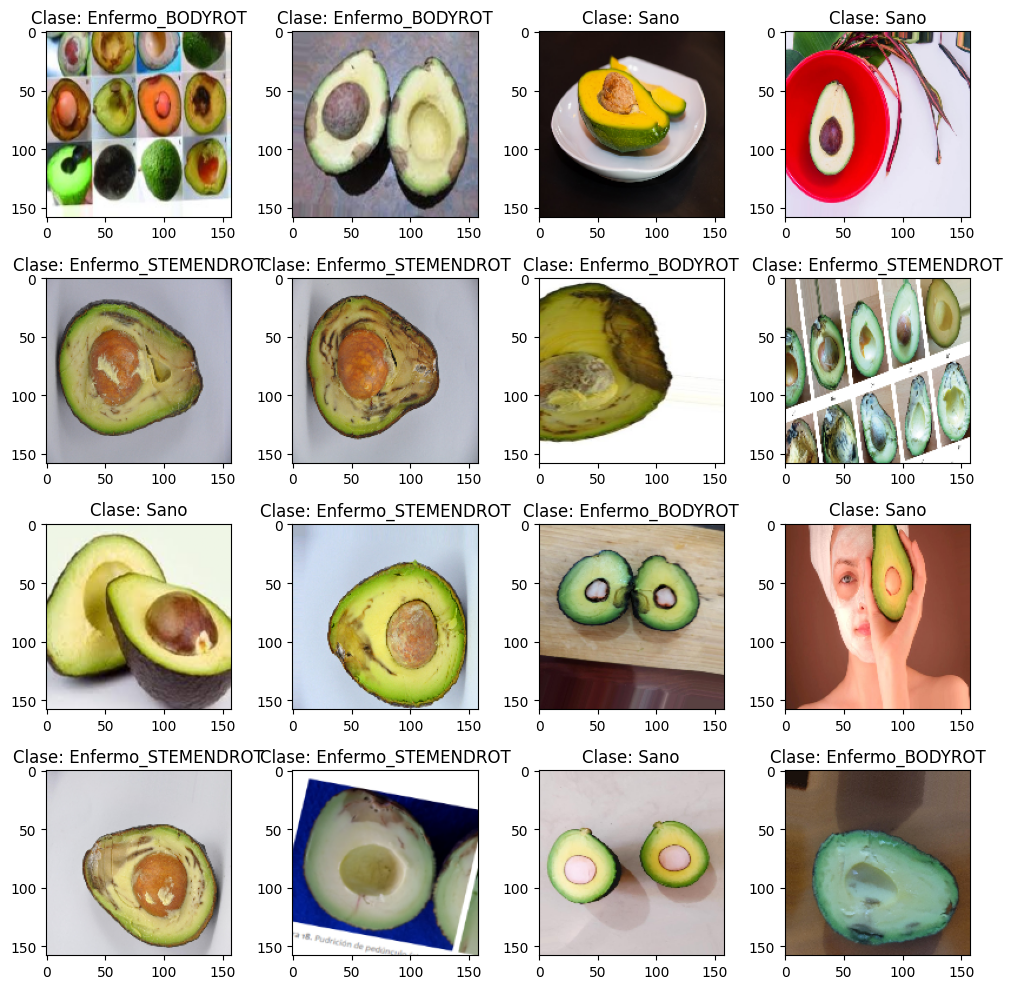

In [25]:
#crea una cuadrícula de subgráficos
fig,ax=plt.subplots(4,4)
#Ajusta el tamaño de la figura
fig.set_size_inches(10,10)
for i in range(4):
    for j in range (4):
        #Selecciona un número aleatorio
        l=rn.randint(0,len(Etiquetas))
        ax[i,j].imshow(Imagenes[l])
        ax[i,j].set_title('Clase: '+clases[Etiquetas[l]])
plt.tight_layout()

In [26]:
#codifica las etiquetas como numeros ESTO ES ONE HOT ENCODING 

#instancia de LabelEncoder, una herramienta de la librería scikit-learn que convierte etiquetas categóricas en números enteros.
codificadorEtiquetas=LabelEncoder()
#Asigna un número entero único a cada clase en Etiquetas
claveEtiquetas=codificadorEtiquetas.fit_transform(Etiquetas)
#Convierte las etiquetas categóricas en vectores one-hot
claveEtiquetas=tf.keras.utils.to_categorical(claveEtiquetas,3)
print(claveEtiquetas)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [27]:
# Convertir listas a arrays para usar en K-Fold SCRIPT EXTRA MIO 
Imagenes = np.array(Imagenes)
Etiquetas = np.array(Etiquetas)

# Configuración de K-Fold Cross Validation
k_folds = 5  # Utilizamos 5 folds para un balance entre validación y rendimiento
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


Entrenando fold 1/5...
Epoch 1/10
31/31 [==============================] - 133s 4s/step - loss: 1.0343 - accuracy: 0.5166 - val_loss: 0.8568 - val_accuracy: 0.5950
Epoch 2/10
31/31 [==============================] - 121s 4s/step - loss: 0.9053 - accuracy: 0.5757 - val_loss: 0.8498 - val_accuracy: 0.6405
Epoch 3/10
31/31 [==============================] - 118s 4s/step - loss: 0.8172 - accuracy: 0.6411 - val_loss: 0.9753 - val_accuracy: 0.5579
Epoch 4/10
31/31 [==============================] - 122s 4s/step - loss: 0.8301 - accuracy: 0.6546 - val_loss: 0.8590 - val_accuracy: 0.5702
Epoch 5/10
31/31 [==============================] - 119s 4s/step - loss: 0.7884 - accuracy: 0.6546 - val_loss: 0.7798 - val_accuracy: 0.6901
Epoch 6/10
31/31 [==============================] - 132s 4s/step - loss: 0.7039 - accuracy: 0.7044 - val_loss: 0.7635 - val_accuracy: 0.7025
Epoch 7/10
31/31 [==============================] - 138s 4s/step - loss: 0.7023 - accuracy: 0.7116 - val_loss: 0.7320 - val_accura

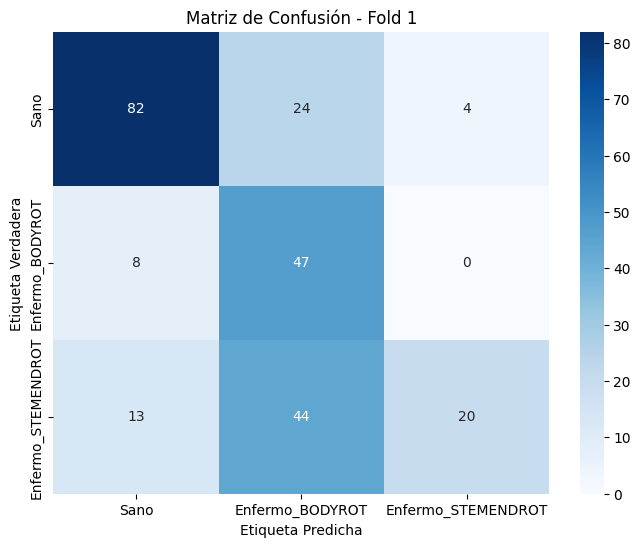


Entrenando fold 2/5...
Epoch 1/10
31/31 [==============================] - 105s 3s/step - loss: 1.0102 - accuracy: 0.5212 - val_loss: 0.9271 - val_accuracy: 0.5311
Epoch 2/10
31/31 [==============================] - 82s 3s/step - loss: 0.9564 - accuracy: 0.5762 - val_loss: 0.8619 - val_accuracy: 0.5809
Epoch 3/10
31/31 [==============================] - 77s 2s/step - loss: 0.8759 - accuracy: 0.6062 - val_loss: 0.8282 - val_accuracy: 0.6266
Epoch 4/10
31/31 [==============================] - 93s 3s/step - loss: 0.8438 - accuracy: 0.6435 - val_loss: 0.8197 - val_accuracy: 0.6515
Epoch 5/10
31/31 [==============================] - 143s 5s/step - loss: 0.7730 - accuracy: 0.6705 - val_loss: 0.7542 - val_accuracy: 0.6846
Epoch 6/10
31/31 [==============================] - 141s 5s/step - loss: 0.7393 - accuracy: 0.7026 - val_loss: 0.7189 - val_accuracy: 0.6805
Epoch 7/10
31/31 [==============================] - 136s 4s/step - loss: 0.7238 - accuracy: 0.6974 - val_loss: 0.7638 - val_accuracy:

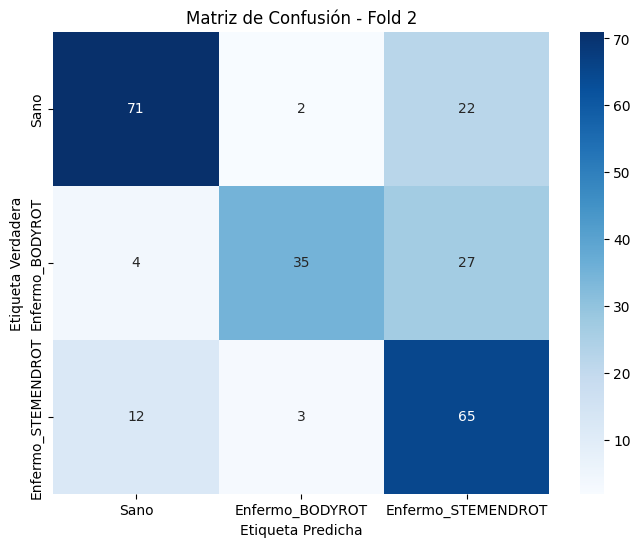


Entrenando fold 3/5...
Epoch 1/10
31/31 [==============================] - 132s 4s/step - loss: 1.0018 - accuracy: 0.5420 - val_loss: 0.9342 - val_accuracy: 0.6183
Epoch 2/10
31/31 [==============================] - 124s 4s/step - loss: 0.8879 - accuracy: 0.6093 - val_loss: 0.8951 - val_accuracy: 0.5892
Epoch 3/10
31/31 [==============================] - 126s 4s/step - loss: 0.8067 - accuracy: 0.6705 - val_loss: 0.8678 - val_accuracy: 0.6058
Epoch 4/10
31/31 [==============================] - 124s 4s/step - loss: 0.7987 - accuracy: 0.6549 - val_loss: 0.8045 - val_accuracy: 0.6722
Epoch 5/10
31/31 [==============================] - 124s 4s/step - loss: 0.8197 - accuracy: 0.6456 - val_loss: 0.7971 - val_accuracy: 0.6639
Epoch 6/10
31/31 [==============================] - 144s 5s/step - loss: 0.7400 - accuracy: 0.6912 - val_loss: 0.7822 - val_accuracy: 0.6680
Epoch 7/10
31/31 [==============================] - 69s 2s/step - loss: 0.6874 - accuracy: 0.7316 - val_loss: 0.7099 - val_accurac

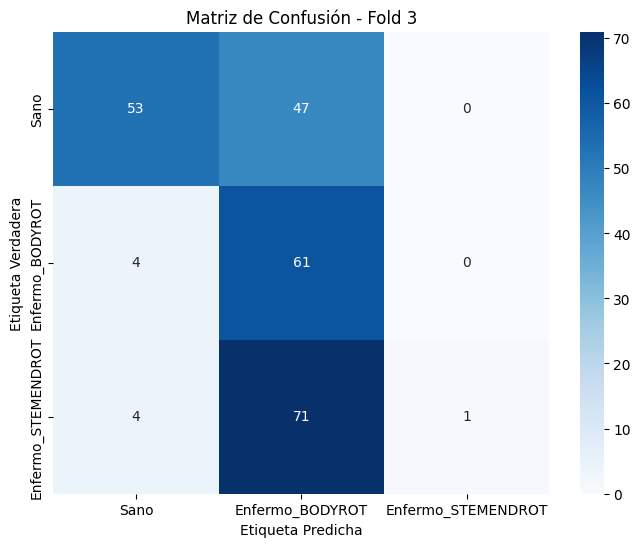


Entrenando fold 4/5...
Epoch 1/10
31/31 [==============================] - 71s 2s/step - loss: 1.0418 - accuracy: 0.5088 - val_loss: 0.9121 - val_accuracy: 0.5560
Epoch 2/10
31/31 [==============================] - 68s 2s/step - loss: 0.9096 - accuracy: 0.5834 - val_loss: 0.8882 - val_accuracy: 0.6183
Epoch 3/10
31/31 [==============================] - 68s 2s/step - loss: 0.8590 - accuracy: 0.6083 - val_loss: 1.2126 - val_accuracy: 0.4523
Epoch 4/10
31/31 [==============================] - 67s 2s/step - loss: 0.9042 - accuracy: 0.5876 - val_loss: 0.8583 - val_accuracy: 0.5975
Epoch 5/10
31/31 [==============================] - 68s 2s/step - loss: 0.7594 - accuracy: 0.6705 - val_loss: 0.9067 - val_accuracy: 0.5726
Epoch 6/10
31/31 [==============================] - 68s 2s/step - loss: 0.7506 - accuracy: 0.6860 - val_loss: 0.8305 - val_accuracy: 0.5975
Epoch 7/10
31/31 [==============================] - 72s 2s/step - loss: 0.7021 - accuracy: 0.7192 - val_loss: 0.8564 - val_accuracy: 0.6

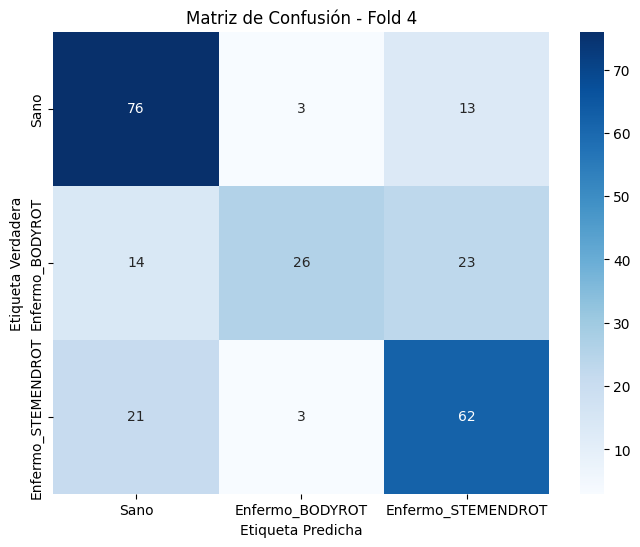


Entrenando fold 5/5...
Epoch 1/10
31/31 [==============================] - 68s 2s/step - loss: 1.0868 - accuracy: 0.5078 - val_loss: 0.9339 - val_accuracy: 0.5436
Epoch 2/10
31/31 [==============================] - 66s 2s/step - loss: 0.8825 - accuracy: 0.6176 - val_loss: 0.9311 - val_accuracy: 0.5768
Epoch 3/10
31/31 [==============================] - 66s 2s/step - loss: 0.8460 - accuracy: 0.6259 - val_loss: 0.8430 - val_accuracy: 0.6680
Epoch 4/10
31/31 [==============================] - 67s 2s/step - loss: 0.7869 - accuracy: 0.6508 - val_loss: 0.8386 - val_accuracy: 0.6473
Epoch 5/10
31/31 [==============================] - 69s 2s/step - loss: 0.7453 - accuracy: 0.6767 - val_loss: 0.9860 - val_accuracy: 0.5934
Epoch 6/10
31/31 [==============================] - 68s 2s/step - loss: 0.7112 - accuracy: 0.7130 - val_loss: 0.7655 - val_accuracy: 0.6888
Epoch 7/10
31/31 [==============================] - 67s 2s/step - loss: 0.6550 - accuracy: 0.7554 - val_loss: 0.8115 - val_accuracy: 0.6

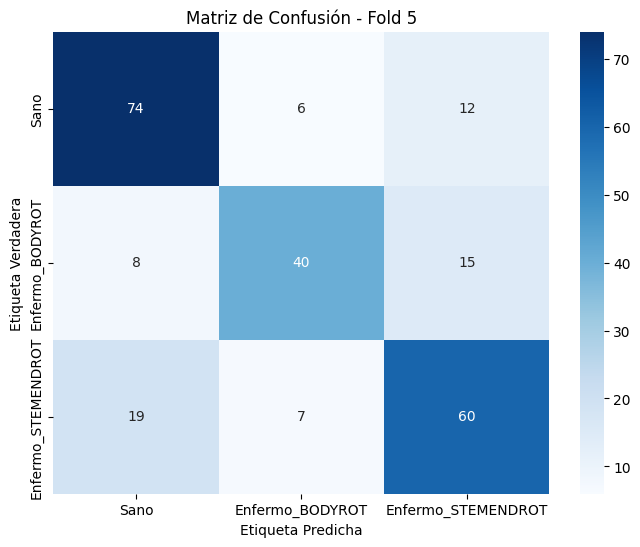


Tiempo total de entrenamiento con K-Fold Cross Validation: 4880.42 segundos


In [28]:
# Medir tiempo de entrenamiento
start_time = time.time()
fold_no = 1
for train_index, val_index in kf.split(Imagenes):
    print(f"\nEntrenando fold {fold_no}/{k_folds}...")

    # Dividir datos en entrenamiento y validación para el fold actual
    img_entrenamiento, img_prueba = Imagenes[train_index], Imagenes[val_index]
    etq_entrenamiento, etq_prueba = Etiquetas[train_index], Etiquetas[val_index]

    # Cargar el modelo base ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    #congelar las capas del modelo
    for layer in base_model.layers:
        layer.trainable = False

    # Agregar capas personalizadas
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predicciones = Dense(num_clases, activation='softmax')(x)

    # Crear el modelo final
    modelo = Model(inputs=base_model.input, outputs=predicciones)
    modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

    # Entrenar el modelo
    modelo.fit(img_entrenamiento, etq_entrenamiento,
               validation_data=(img_prueba, etq_prueba),
               epochs=10, batch_size=32, verbose=1)

    # Generar predicciones y matriz de confusión

    predicciones = modelo.predict(img_prueba)
    print("Forma de predicciones:", predicciones.shape)  # Esto debería ser (n_samples, n_classes)
    
    predicciones_etq = np.argmax(predicciones, axis=1)
    if etq_prueba.ndim == 2:
        etq_prueba_etq = np.argmax(etq_prueba, axis=1)
    else:
        etq_prueba_etq = etq_prueba

    

    #predicciones_etq = np.argmax(predicciones, axis=1)              
    #etq_prueba_etq = np.argmax(etq_prueba, axis=1)  # Convertir a etiquetas para la matriz de confusió


    print("Forma de etq_prueba_etq:", etq_prueba_etq.shape)
    print("Forma de etq_prueba:", predicciones_etq.shape)


    # Crear y mostrar la matriz de confusión para este fold
    matriz_confusion = confusion_matrix(etq_prueba_etq, predicciones_etq)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    plt.title(f'Matriz de Confusión - Fold {fold_no}')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

    fold_no += 1
# Calcular y mostrar tiempo total de entrenamiento
end_time = time.time()
total_time = end_time - start_time
print(f"\nTiempo total de entrenamiento con K-Fold Cross Validation: {total_time:.2f} segundos")


In [30]:
#matriz general:
a1 = .74
a2 = 0.67
a3 = 0.64
a4 = 0.68
a5 = 0.70

AC_total = (a1 + a2 + a3 + a4 + a5)/5
print(AC_total)

0.6860000000000002


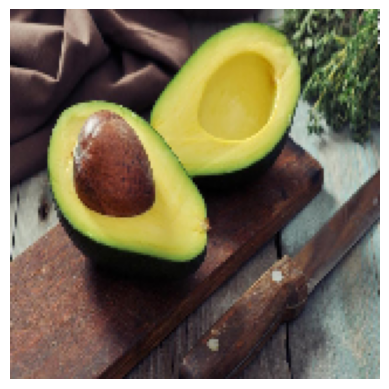

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
La imagen pertenece a la clase: Enfermo_STEMENDROT


In [ ]:
# Definir las clases que estás utilizando
clases = ['Sano', 'Enfermo_BODYROT', 'Enfermo_STEMENDROT']

# Función para predecir una imagen
def predecir_imagen(ruta_imagen, modelo, clases, img_tam=158):
    # Cargar la imagen
    img = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(img_tam, img_tam))

    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convertir la imagen a un array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Redimensionar y normalizar la imagen
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Expandir la dimensión para que sea compatible con el modelo

    # Hacer la predicción
    prediccion = modelo.predict(img_array)

    # Obtener la clase predicha
    clase_predicha = np.argmax(prediccion, axis=1)[0]

    # Mostrar el resultado
    print(f"La imagen pertenece a la clase: {clases[clase_predicha]}")

# Ejemplo de uso
ruta_imagen = 'aguacateprueba.jpg'  # Cambiar a la ruta de tu imagen
predecir_imagen(ruta_imagen, modelo, clases)